# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

!pip install mmcv 

In [1]:
from time import time

In [2]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def plot_img(img: np.array, figsize: tuple = (5, 5), savefig: str = None):
    """ 
    img -> np.array,
    figsize -> tuple,
    savefig -> str
    """
    if img.size == 0:
        print(" ОШИБКА!!!!!!Массив img пустой, невозможно создать изображение.")
        return
    plt.figure(figsize = figsize)
    plt.imshow(img)
    if savefig:
        plt.savefig(savefig)
    plt.show()

In [4]:
def extract(frame: np.array, boxes: np.array):
    """
    Extract images of face from 'frame' with bboxes from 'boxes'
    """
    #x_ranges = [range(*bounds) for bounds in boxes[:, ::2].astype(int)]
    #y_ranges = [range(*bounds) for bounds in boxes[:, 1::2].astype(int)]
    #faces = [frame[y][:, x] for x, y in zip(x_ranges, y_ranges)]
    faces = []
    for bounds in boxes:
        x_start, x_end, y_start, y_end = bounds.astype(int)
        face = frame[y_start:y_end, x_start:x_end]
        faces.append(face)
    return faces

In [5]:
!nvidia-smi

Tue Feb 20 16:00:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:3A:00.0 Off |                    0 |
| N/A   28C    P0              54W / 300W |   7895MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Determine if an nvidia GPU is available

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = 'cpu'



print('Running on device: {}'.format(device))

Running on device: cpu


In [7]:
mtcnn = MTCNN(keep_all=True, device=device)

#### Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

video = mmcv.VideoReader('inferenceB.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('inferenceB.mp4', width=640)

In [8]:
video = mmcv.VideoReader('./videos/1.webm')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('videos/1.webm', width=640)

In [9]:
len(video)

735919

In [10]:
video[0].shape

(901, 1349, 3)

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [11]:
start = time()


threshold = 0.5

frames_tracked = []
center_coordinates_list = []
boxes_list = []
probs_list = []
landmarks_list = []
  
for i, frame in enumerate(frames[100:]):
    print('\rTracking frame: {}'.format(i), end='')
    
    # Detect faces
    boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    
    if boxes is not None:
        keep = np.where(probs > threshold)
        boxes = boxes[keep]
        landmarks = landmarks[keep]
        center_coordinates = (np.vstack([((boxes[:, 0] + boxes[:, 2])/2), ((boxes[:, 1] + boxes[:, 3])/2)])).astype('int').T
    
    
#     print((boxes.shape[0]))
#     for i in range(((boxes.shape[0]))):
#         print((int((boxes[i][0]+boxes[i][2])/2), int((boxes[i][2]+boxes[i][3])/2)))
#     (frame.show())
    
        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)

        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=3)
        
#     for pnt in center_coordinates:    
#         draw.rectangle(np.hstack([(pnt-3), (pnt+3)]).tolist(), outline=(255, 0, 0), width=2)
    
        # Add to frame list
        frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
        center_coordinates_list.append(center_coordinates)
        boxes_list.append(boxes)
        probs_list.append(probs)
        landmarks_list.append(landmarks)
    
print('\nDone')

Tracking frame: 20672
Done


In [12]:
end = time()

In [13]:
start-end

-1276.0023639202118

In [14]:
len(boxes_list)

5933

In [15]:
faces = extract(np.array(frames[0]), boxes_list[0])

faces_list = []
faces_list.append(faces)

#### Display detections

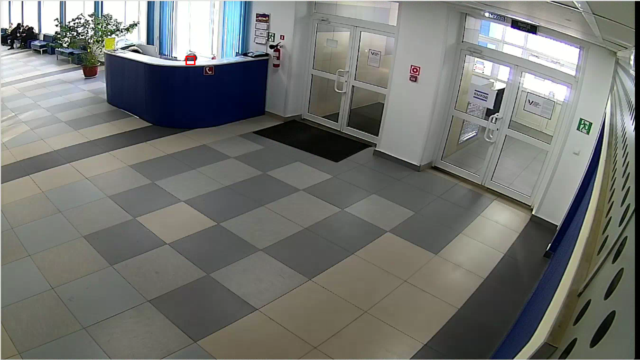

In [16]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
for i in range(len(frames_tracked)):
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1

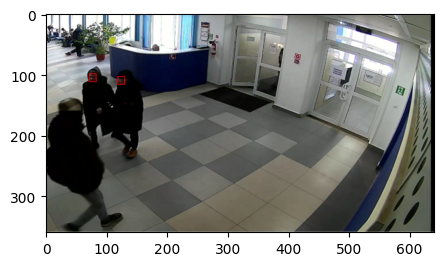

In [17]:
plot_img(frames_tracked[5000])

#### Save tracked video

dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()